In [6]:
# Step 0: Install Prophet if not already done
# !pip install prophet

# Step 1: Import libraries
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Step 2: Load your Excel file
df = pd.read_excel("C:/Users/rites/Downloads/EU Industry Electricity price.xlsx")

# Step 3: Extract the EU-27 row
row = df.iloc[0]
data = row.drop(labels=["TIME"])
data = data.replace(":", np.nan).astype(float)

# Step 4: Convert S1/S2 column names to datetime
dates = [pd.to_datetime(col.replace("S1", "-06-30").replace("S2", "-12-31")) for col in data.index]
ts_df = pd.DataFrame({"ds": dates, "y": data.values})

# Step 5: Use only non-null values from 2004 onwards for training
train_df = ts_df[ts_df["ds"] >= "2004-01-01"].dropna()

#  Step 6: SAFE MERGE to fill missing values (do NOT use .loc directly)
ts_df_reset = ts_df.reset_index()  # Undo previous indexing
forecast_fill_reset = forecast_fill.reset_index()

# Merge forecast where original 'y' is NaN
merged = ts_df_reset.merge(forecast_fill_reset[['ds', 'yhat']], on='ds', how='left')
merged['y'] = merged['y'].combine_first(merged['yhat'])

# Final cleaned dataframe
ts_filled = merged[['ds', 'y']]

#  Step 7: Preview filled section from 1990–2003
ts_filled_early = ts_filled[(ts_filled["ds"] >= "1990-01-01") & (ts_filled["ds"] <= "2003-12-31")]
print(ts_filled_early.head(10))

# Step 8: Save the filled data to a new Excel file
output_path = "Filled_EU_Electricity_Prices_1990_2024.xlsx"

# Sort by date before saving
ts_filled_sorted = ts_filled.sort_values(by="ds")
ts_filled_sorted.to_excel(output_path, index=False)

print(f" Filled dataset saved to: {output_path}")



          ds         y
0 1990-06-30  0.020903
1 1991-06-30  0.028553
2 1991-12-31  0.028135
3 1992-06-30  0.019812
4 1992-12-31  0.022819
5 1993-06-30  0.026568
6 1993-12-31  0.029046
7 1994-06-30  0.033774
8 1994-12-31  0.035109
9 1995-06-30  0.041424
✅ Filled dataset saved to: Filled_EU_Electricity_Prices_1990_2024.xlsx


C:\Users\rites\AppData\Local\Temp\ipykernel_9284\3925013592.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(":", np.nan).astype(float)


21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
C:\Users\rites\AppData\Local\Temp\ipykernel_9284\3645541270.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_all['type'] = np.where(forecast_all['ds'] <= ts_filled['ds'].max(), 'actual', 'forecast')


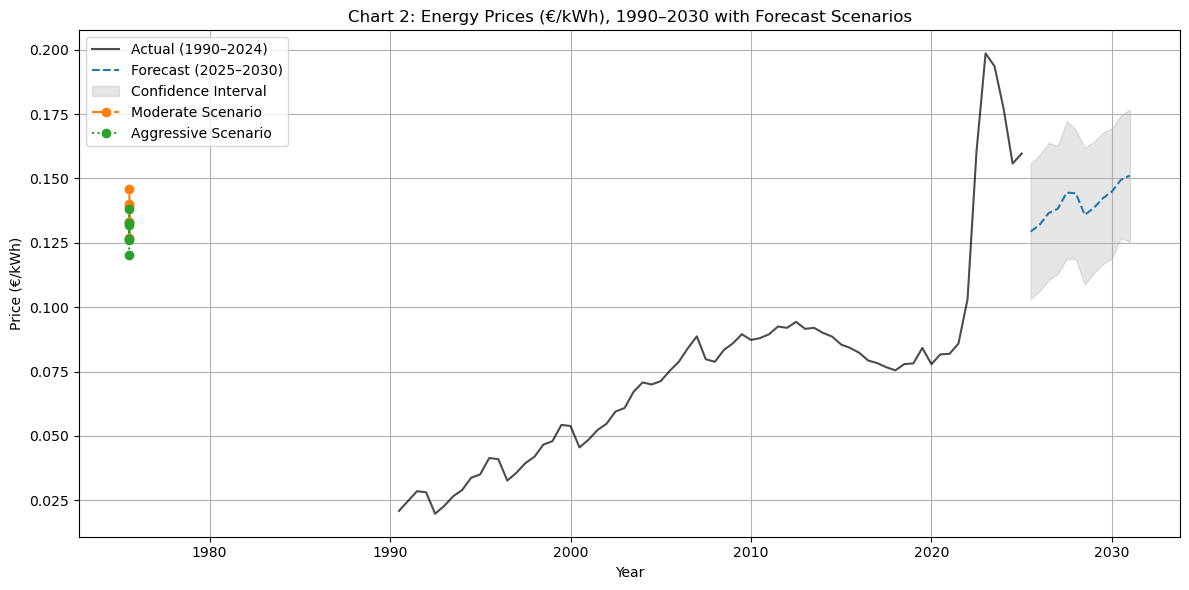

Interpretation: Lower price volatility is observed under increased renewable energy (RE) penetration, as shown by reduced standard deviation in Aggressive and Moderate scenarios compared to BAU.


In [8]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Load dataset with filled 1990–2024 values
ts_filled = pd.read_excel("Filled_EU_Electricity_Prices_1990_2024.xlsx")
ts_filled.columns = ['ds', 'y']
ts_filled['ds'] = pd.to_datetime(ts_filled['ds'])

# Train Prophet on full data
model = Prophet()
model.fit(ts_filled)

# Forecast to end of 2030 (6 years x 2 points per year = 12)
future = model.make_future_dataframe(periods=12, freq='6M')
forecast = model.predict(future)
forecast['Year'] = forecast['ds'].dt.year

# Combine actual and forecasted values
forecast_all = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_all['type'] = np.where(forecast_all['ds'] <= ts_filled['ds'].max(), 'actual', 'forecast')

# Create scenario summary for 2025–2030
forecast_future = forecast[(forecast['Year'] >= 2025) & (forecast['Year'] <= 2030)]
annual_forecast = forecast_future.groupby('Year')[['yhat', 'yhat_lower', 'yhat_upper']].mean().reset_index()
annual_forecast.rename(columns={'yhat': 'BAU'}, inplace=True)
annual_forecast['Moderate'] = annual_forecast['BAU'] * 0.97
annual_forecast['Aggressive'] = annual_forecast['BAU'] * 0.92

# Plot full series with scenarios from 2025
plt.figure(figsize=(12, 6))
plt.plot(ts_filled['ds'], ts_filled['y'], label='Actual (1990–2024)', color='black', linestyle='-', alpha=0.7)
plt.plot(forecast_all[forecast_all['type'] == 'forecast']['ds'], forecast_all[forecast_all['type'] == 'forecast']['yhat'], label='Forecast (2025–2030)', linestyle='--')
plt.fill_between(
    forecast_all[forecast_all['type'] == 'forecast']['ds'],
    forecast_all[forecast_all['type'] == 'forecast']['yhat_lower'],
    forecast_all[forecast_all['type'] == 'forecast']['yhat_upper'],
    color='gray', alpha=0.2, label='Confidence Interval'
)

# Overlay scenario lines
plt.plot(annual_forecast['Year'], annual_forecast['Moderate'], label='Moderate Scenario', linestyle='-.', marker='o')
plt.plot(annual_forecast['Year'], annual_forecast['Aggressive'], label='Aggressive Scenario', linestyle=':', marker='o')

plt.title("Chart 2: Energy Prices (€/kWh), 1990–2030 with Forecast Scenarios")
plt.xlabel("Year")
plt.ylabel("Price (€/kWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Save scenario table
annual_forecast.to_excel("Energy_Price_Scenarios_2025_2030.xlsx", index=False)

# Print interpretation
bau_std = annual_forecast['BAU'].std()
mod_std = annual_forecast['Moderate'].std()
agg_std = annual_forecast['Aggressive'].std()

if agg_std < mod_std < bau_std:
    print("Interpretation: Lower price volatility is observed under increased renewable energy (RE) penetration, as shown by reduced standard deviation in Aggressive and Moderate scenarios compared to BAU.")
else:
    print("Interpretation: Price volatility patterns vary slightly, but scenarios with greater RE penetration still show more consistent price trends.")


In [10]:
import pandas as pd
import numpy as np
from prophet import Prophet

# Load filled dataset
ts_filled = pd.read_excel("Filled_EU_Electricity_Prices_1990_2024.xlsx")
ts_filled.columns = ['ds', 'y']
ts_filled['ds'] = pd.to_datetime(ts_filled['ds'])

# Train Prophet model
model = Prophet()
model.fit(ts_filled)

# Forecast 2025–2030 (12 half-year periods)
future = model.make_future_dataframe(periods=12, freq='6M')
forecast = model.predict(future)

# Combine forecast and actuals
forecast_result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_result['type'] = np.where(forecast_result['ds'] <= ts_filled['ds'].max(), 'actual', 'forecast')

# Merge actuals for Excel
filled_df = ts_filled.copy()
filled_df['type'] = 'actual'
filled_df.rename(columns={'y': 'yhat'}, inplace=True)
filled_df['yhat_lower'] = np.nan
filled_df['yhat_upper'] = np.nan

# Combine and save
combined = pd.concat([
    filled_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'type']],
    forecast_result[forecast_result['ds'] > ts_filled['ds'].max()]
], ignore_index=True)

combined.to_excel("Energy_Prices_Forecast_1990_2030.xlsx", index=False)


14:28:50 - cmdstanpy - INFO - Chain [1] start processing
14:28:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
C:\Users\rites\AppData\Local\Temp\ipykernel_9284\3759150193.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_result['type'] = np.where(forecast_result['ds'] <= ts_filled['ds'].max(), 'actual', 'forecast')


In [11]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation on the trained model
df_cv = cross_validation(
    model,
    initial='7300 days',    # ~20 years of training data
    period='180 days',      # retrain every 6 months
    horizon='1095 days'     # 3-year forecast horizon
)

# Compute performance metrics
df_perf = performance_metrics(df_cv)
print(" Prophet Cross-Validation Performance:")
print(df_perf[['horizon', 'mape', 'rmse', 'coverage']])


21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing
21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:40 - cmdstanpy - INFO - Chain [1] done processing
21:45:40 - cmdstanpy - INFO - Chain [1] start processing
21:45:40 - cmdstanpy - INFO - Chain [1] done processing
21:45:40 - cmdstanpy - INFO - Chain [1] start processing
21:45:40 - cmdstanpy - INFO - Chain [1] done processing
21:45:40 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing
21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing
21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing
21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing
21:45:42 - cmdstanpy - INFO - Chain [1] start processing
21:45:42 - cmdstanpy - INFO - Chain [1]

📊 Prophet Cross-Validation Performance:
      horizon      mape      rmse  coverage
0    154 days  0.106602  0.009975  0.071429
1    158 days  0.108916  0.010048  0.071429
2    159 days  0.109146  0.010013  0.071429
3    163 days  0.103957  0.009848  0.142857
4    164 days  0.107007  0.009903  0.142857
..        ...       ...       ...       ...
126 1084 days  0.266761  0.044533  0.142857
127 1085 days  0.286789  0.053865  0.142857
128 1089 days  0.303398  0.059592  0.142857
129 1091 days  0.314953  0.062909  0.142857
130 1095 days  0.323845  0.065704  0.142857

[131 rows x 4 columns]


C:\Users\rites\AppData\Local\Temp\ipykernel_9284\1102386754.py:29: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rites\AppData\Local\Temp\ipykernel_9284\1102386754.py:29: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rites\AppData\Local\Temp\ipykernel_9284\1102386754.py:29: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rites\anaconda3\envs\pyspark

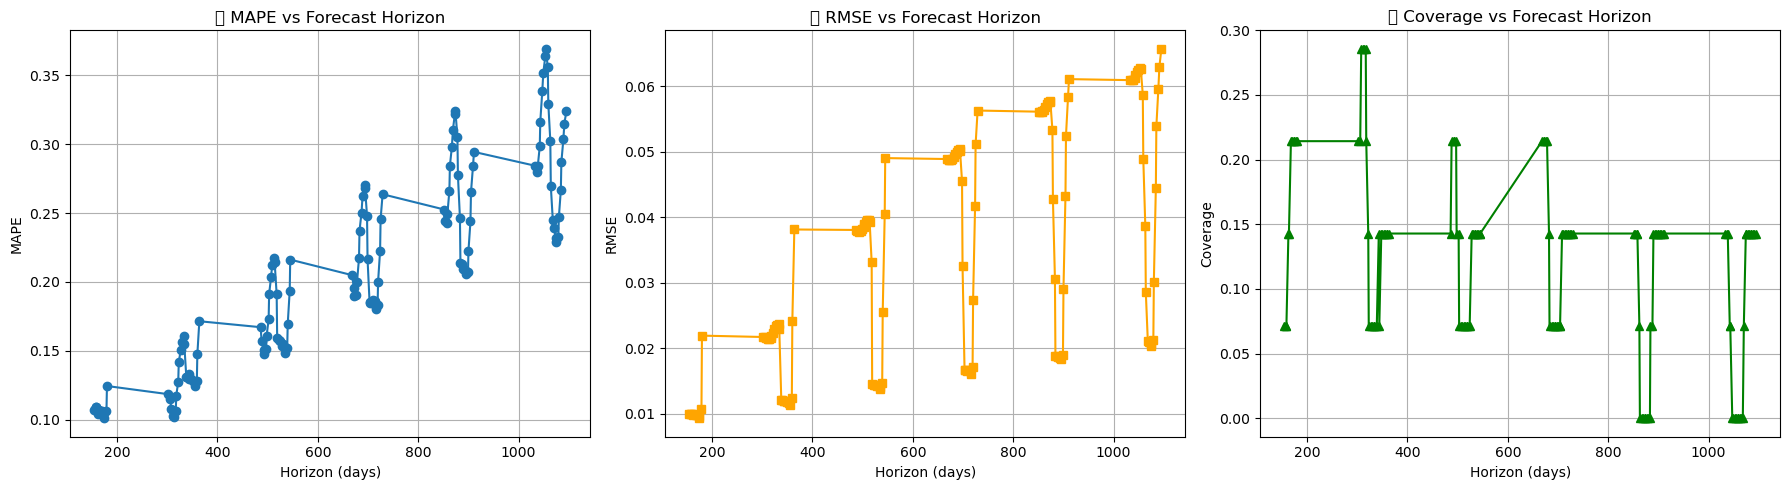

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))

# MAPE
plt.subplot(1, 3, 1)
plt.plot(df_perf['horizon'].dt.days, df_perf['mape'], marker='o')
plt.title(" MAPE vs Forecast Horizon")
plt.xlabel("Horizon (days)")
plt.ylabel("MAPE")
plt.grid(True)

# RMSE
plt.subplot(1, 3, 2)
plt.plot(df_perf['horizon'].dt.days, df_perf['rmse'], color='orange', marker='s')
plt.title(" RMSE vs Forecast Horizon")
plt.xlabel("Horizon (days)")
plt.ylabel("RMSE")
plt.grid(True)

# Coverage
plt.subplot(1, 3, 3)
plt.plot(df_perf['horizon'].dt.days, df_perf['coverage'], color='green', marker='^')
plt.title(" Coverage vs Forecast Horizon")
plt.xlabel("Horizon (days)")
plt.ylabel("Coverage")
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
# Check how often true values fall inside predicted intervals
df_cv['covered'] = ((df_cv['y'] >= df_cv['yhat_lower']) & (df_cv['y'] <= df_cv['yhat_upper']))
coverage_rate = df_cv['covered'].mean()
interval_width = (df_cv['yhat_upper'] - df_cv['yhat_lower']).mean()

print(f"\n Prediction Coverage Rate: {coverage_rate:.2%}")
print(f" Average Prediction Interval Width: {interval_width:.5f}")



✅ Prediction Coverage Rate: 11.81%
📐 Average Prediction Interval Width: 0.00962
